# Advanced Lane Finding

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

NOTE. The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. The video called project_video.mp4 is the video your pipeline should work well on. challenge_video.mp4 is an extra (and optional) challenge for you if you want to test your pipeline.

If you're feeling ambitious (totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import glob, os
from scipy import misc
from scipy.misc import imresize
import pickle
import matplotlib.image as mpimg

In [2]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray)
    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)


    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #print(gradmag)

    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Here supress error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    #print(s)
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    
    #print(s_binary)
    
    
    return s_binary

In [3]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        ax.set_xticks([])
        ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

In [4]:
gradx_l = []
grady_l = []
mag_binary_l = []
dir_binary_l = []
combined_l = []
hls_list = []
ksize = 15


# Make a list of test images

images = glob.glob('test_images/undis*.jpg')
for idx, image in enumerate(images):
    name = image.split('/')
    img =  mpimg.imread(image)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh= (0.7, 1.4))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    convert2hls = rgb2hls(img,thresh=(150, 250))
    
    gradx_l.append(gradx)
    grady_l.append(grady)
    mag_binary_l.append(mag_binary)
    dir_binary_l.append(dir_binary)
    combined_l.append(combined)
    hls_list.append(convert2hls)

# Plot the result   
n_row = 3
n_col =2


In [5]:
#show_images(gradx_l,n_row,n_col,"Gradx")

In [6]:
#show_images(grady_l,n_row,n_col,"Grady")

In [7]:
#show_images(mag_binary_l,n_row,n_col,"Magnitude")

In [8]:
#show_images(dir_binary_l,n_row,n_col,"Direction")

In [9]:
#show_images(combined_l,n_row,n_col,"Combined")

In [10]:
#show_images(hls_list,n_row,n_col,"HLS")

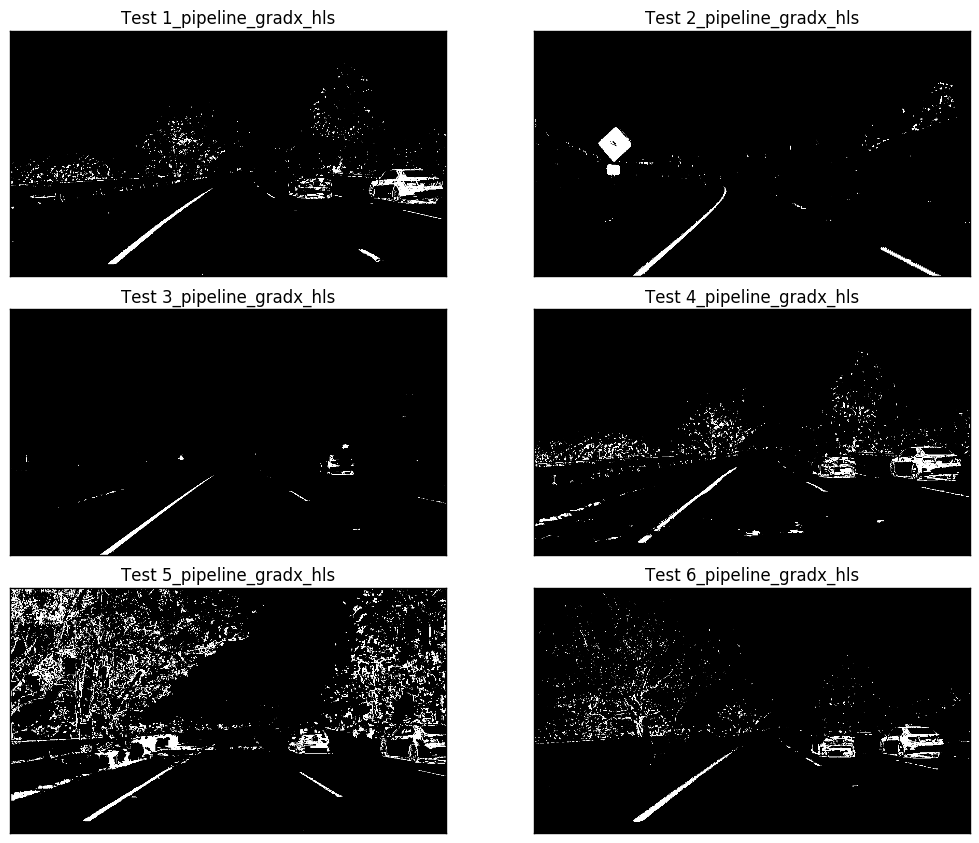

In [11]:
%matplotlib inline
def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= rgb2hls(img, thresh=(150, 250))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(100, 250))

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    
images_filtered =[]
images = glob.glob('test_images/*.jpg')
for idx, image in enumerate(images):
    name = image.split('/')
    img =  mpimg.imread(image)
    filtered= pipeline_gradx_hls(img)
    #print (filtered)
    images_filtered.append(filtered)

show_images(images_filtered,n_row,n_col,"pipeline_gradx_hls")
    

In [12]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print(mtx.shape)
#print(dist.shape)


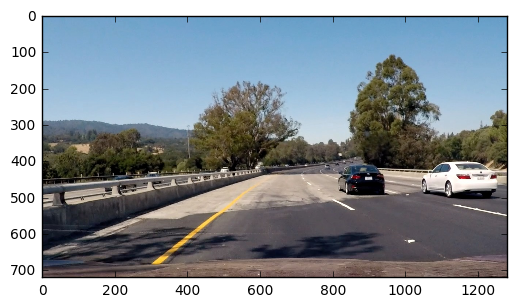

In [13]:
# Read in an image
%matplotlib inline
img = mpimg.imread('test_images/test4.jpg')

plt.imshow(img)


In [14]:
def corners_unwarp(img, nx, ny, mtx, dist):  
    img_size = (img.shape[1],img.shape[0])
    offset = 100
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #gray = cv2.cvtColor(undst,cv2.COLOR_BGR2GRAY)
    
    corners_ul = (531,501)
    corners_ur = (795,501)
    corners_bl = (492,534)
    corners_br = (853,534)
    
    
    
    src = np.float32([corners_ul, corners_ur, corners_br, corners_bl])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(undst, M, img_size)      

 
    return warped, M



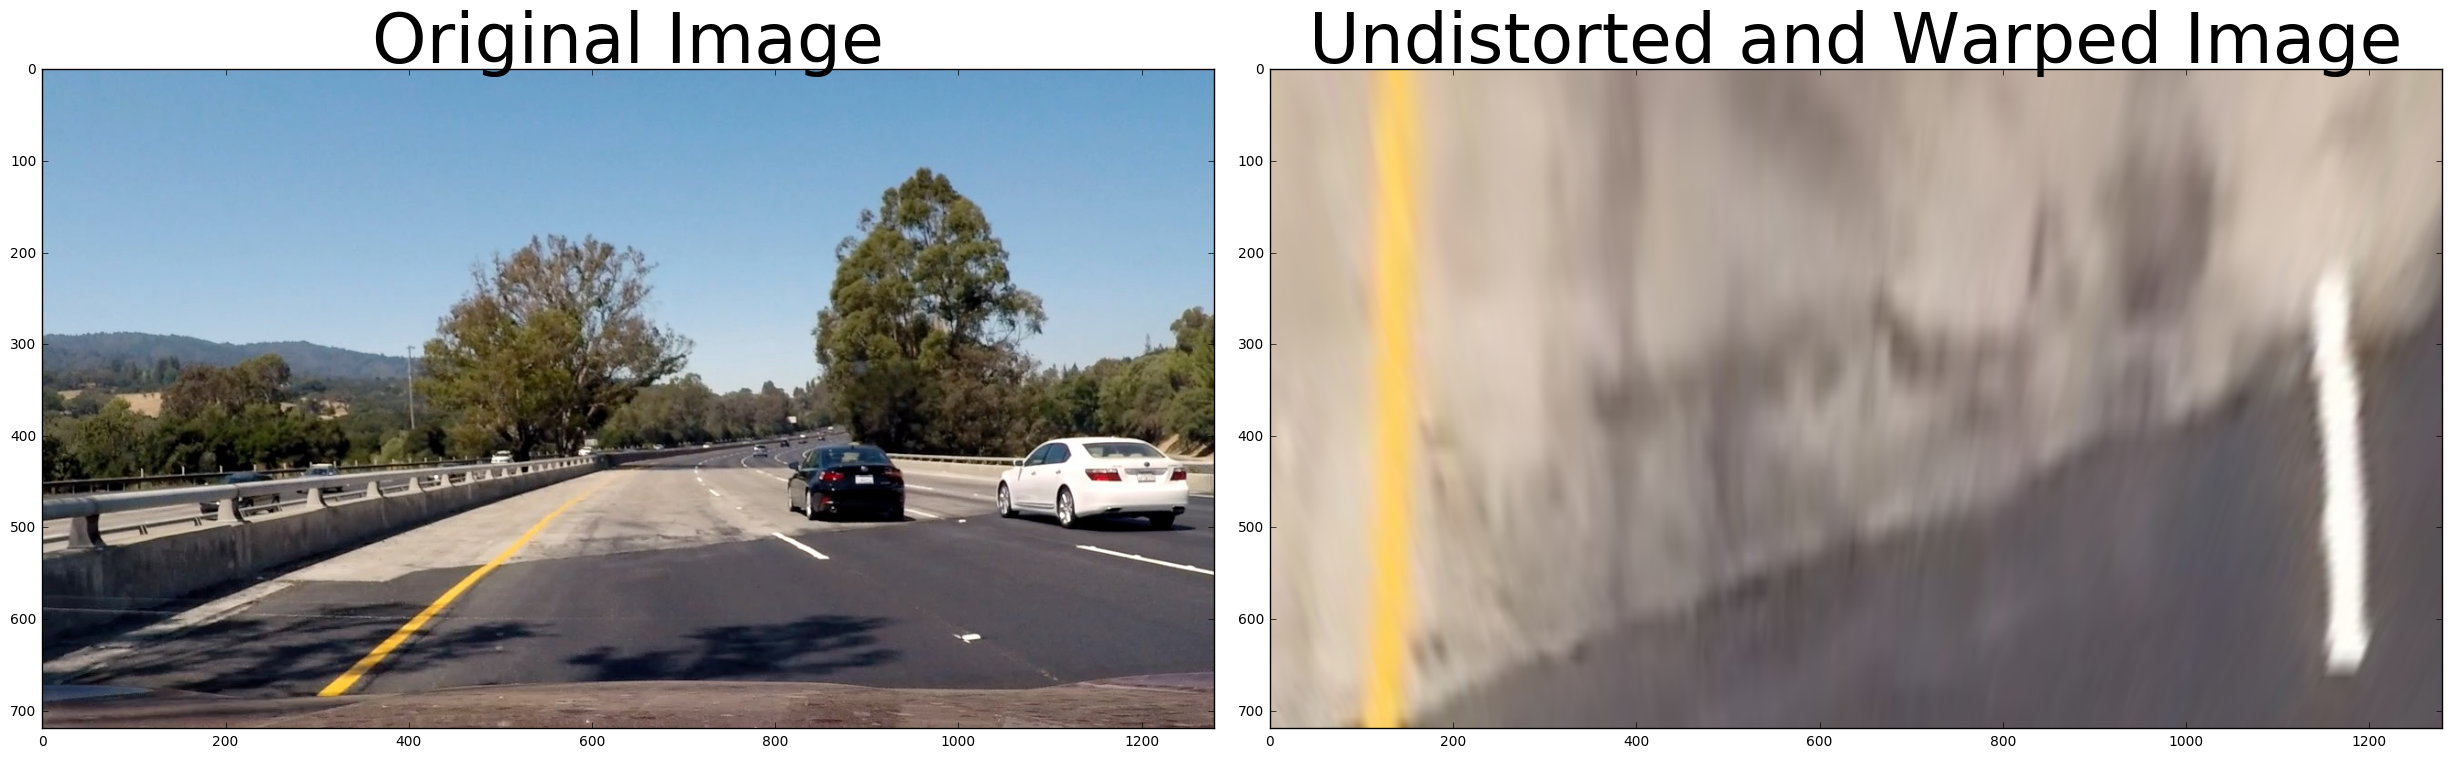

In [20]:
%matplotlib inline
nx = 9
ny = 6

img = mpimg.imread('test_images/test4.jpg')

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

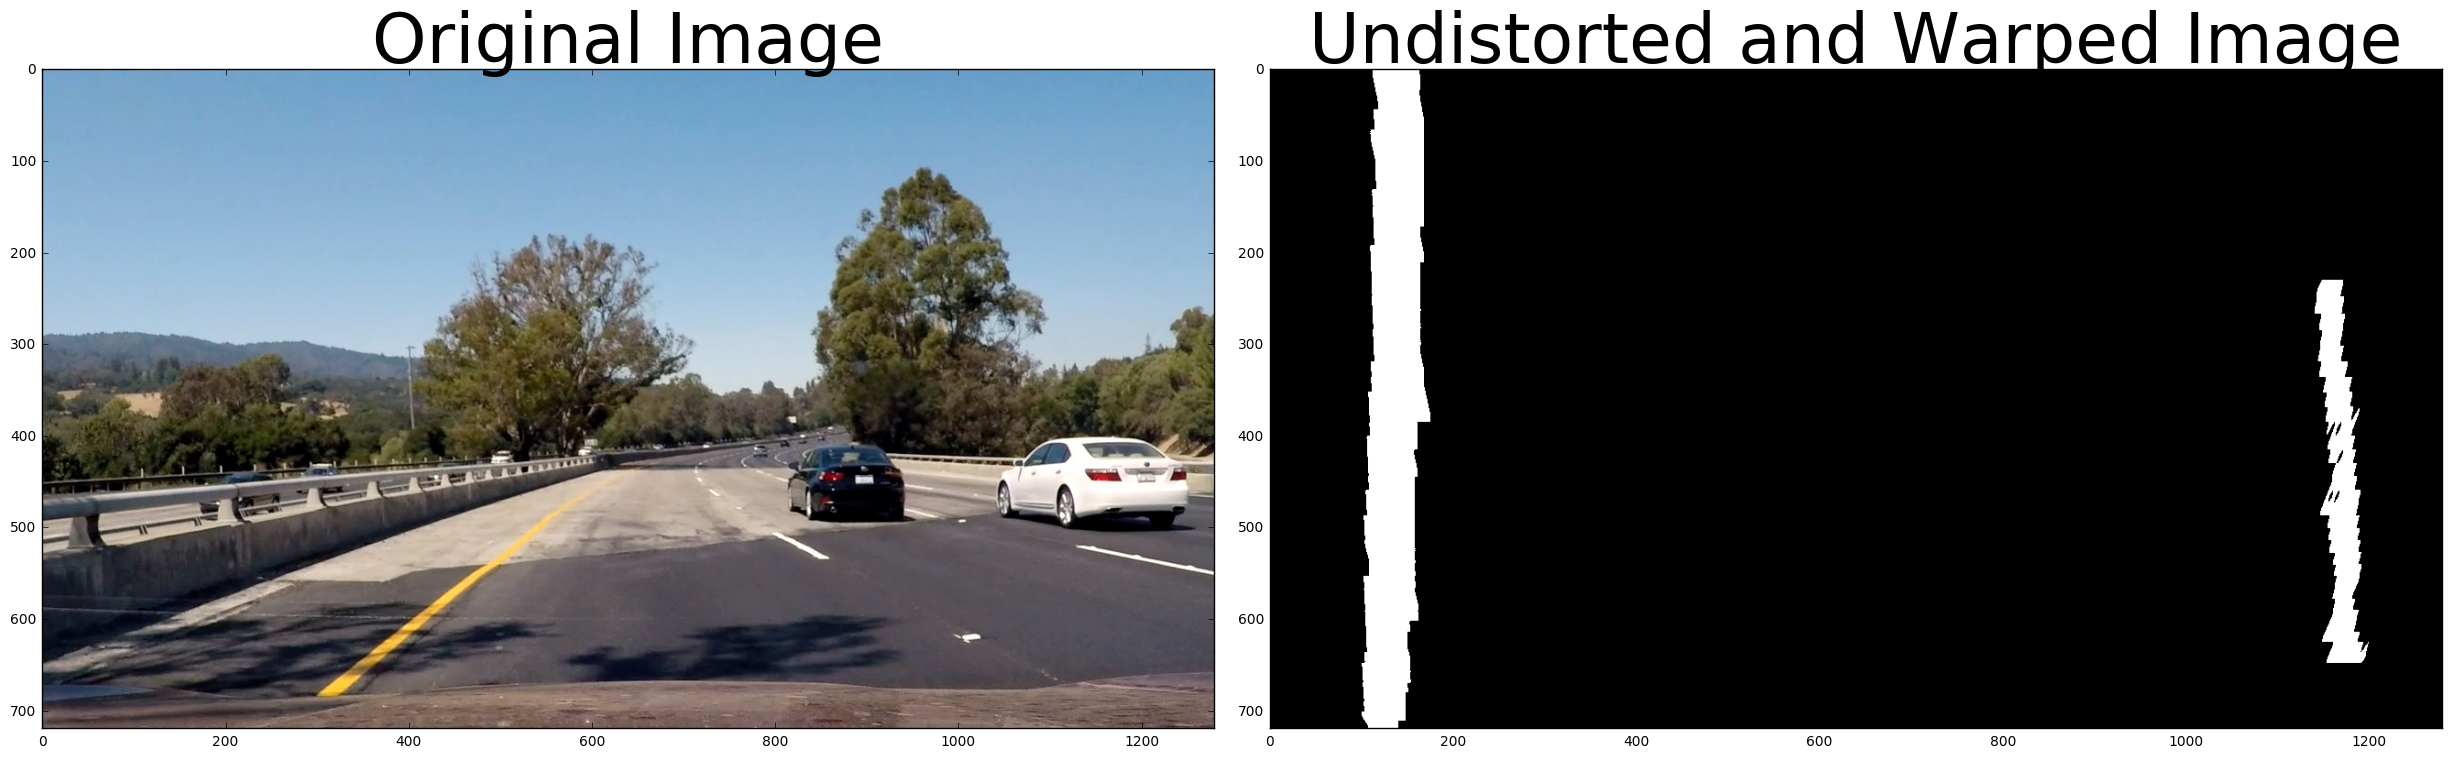

In [21]:
%matplotlib inline
img = mpimg.imread('test_images/test4.jpg')
result = pipeline_gradx_hls(img)
top_down, perspective_M = corners_unwarp(result, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

/root/miniconda3/envs/carnd_term_1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


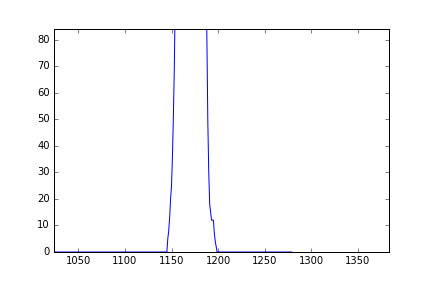

In [40]:
from matplotlib import interactive
interactive(True)
%matplotlib notebook 

histogram = np.sum(top_down[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [70]:
lane_1 = []
lane_2 = []

for x in range(img.shape[1]):
    if x == 0:
        last = histogram[0]
        
    else:
        if histogram[x] > last and len(lane_1) == 0:
            lane_1.append(x)
            last = histogram[x]
            
        if histogram[x] < last and len(lane_1) == 1:
            lane_1.append(x)
            last = histogram[x]
            final_l1= lane_1[1]
        if x > final_l1:
            if histogram[x] > last and len(lane_2) == 0:
                lane_2.append(x)
                last = histogram[x]
                
            if histogram[x] < last and len(lane_2) == 1:
                lane_2.append(x)
                last = histogram[x]
            
print(lane_1)
print(lane_2)
    

[100, 175]
[1146, 1197]


In [46]:
from scipy import signal
x = np.arange(5,100)
pixels = np.arange(1,1400)
peakind = signal.find_peaks_cwt(histogram, x)

filter_peaks = []

if len(peakind) >= 2:
    max_peakind = [0,1]
    for peak in peakind:
        if histogram[peak] > histogram[max_peakind[0]]:
            max_peakind[1] = max_peakind[0]
            max_peakind[0] = peak
            
        elif histogram[peak] > histogram[max_peakind[1]]:
            max_peakind[1] = peak
            
            
else: 
    raise Exception('There should be a minimum of two peaks')
                
    #first_peak = np.argmax([histogram[x] for x in peakind])
    #histogram = np.delete(histogram, first_peak)
    #peakind = np.delete(peakind, first_peak)
    #second_peak = np.argmax([histogram[x] for x in peakind])
        
print (histogram[max_peakind[0]], histogram[max_peakind[1]])
print (max_peakind[0], max_peakind[1])    

360 289
126 1174
